#Exploratory Analysis

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


##Load data

more info in the topic of gas costs here:
http://ethdocs.org/en/latest/contracts-and-transactions/account-types-gas-and-transactions.html


In [2]:
df = pd.read_csv('./../data/data.csv')

In [3]:
df.shape

(1494279, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494279 entries, 0 to 1494278
Data columns (total 23 columns):
Unnamed: 0      1494279 non-null int64
hash_t          1494279 non-null object
accountNonce    1494279 non-null int64
amount          1494279 non-null float64
block_id        1494279 non-null int64
gasLimit_t      1494279 non-null int64
gasUsed_t       1494279 non-null int64
isContractTx    0 non-null float64
newContract     1494279 non-null int64
price           1494279 non-null float64
time_t          1494279 non-null object
txIndex         515711 non-null float64
type            1494279 non-null object
blockTime       1494279 non-null int64
difficulty      1494279 non-null object
gasLimit_b      1494279 non-null float64
gasUsed_b       1494279 non-null float64
reward          1494279 non-null object
size            1494279 non-null int64
time_b          1494279 non-null object
totalFee        1494279 non-null object
tx_count        1494279 non-null int64
uncle_count     1

In [5]:
print('no txs: {}, no blocks: {}'.format(df.shape[0], np.unique(df['block_id'].values).shape[0]))

no txs: 1494279, no blocks: 14583


## Convert dates to datetime

In [6]:
df.loc[:,'time_t'] = pd.to_datetime(df.time_t, yearfirst=True)

In [7]:
df.loc[:,'time_b'] = pd.to_datetime(df.time_b, yearfirst=True)

In [8]:
df['time_t'].head()

0   2017-09-20 20:24:15
1   2017-09-20 20:24:15
2   2017-09-20 20:24:15
3   2017-09-20 20:24:15
4   2017-09-20 20:24:15
Name: time_t, dtype: datetime64[ns]

In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

## Convert long integer columns
- difficulty
- reward
- totalFee

Filter each string extracting the digits as integers

In [10]:
int(filter(str.isdigit, df['difficulty'][0]))

2338428842518947

In [11]:
df['difficulty'] = df['difficulty'].apply(lambda x: int(filter(str.isdigit, x)))

In [12]:
df['difficulty'].head()

0    2338428842518947
1    2338428842518947
2    2338428842518947
3    2338428842518947
4    2338428842518947
Name: difficulty, dtype: int64

In [13]:
df['reward'] = df['reward'].apply(lambda x: int(filter(str.isdigit, x)))

In [14]:
df['reward'].head()

0    5008232105000000000
1    5008232105000000000
2    5008232105000000000
3    5008232105000000000
4    5008232105000000000
Name: reward, dtype: int64

In [15]:
df['totalFee'] = df['totalFee'].apply(lambda x: int(filter(str.isdigit, x)))

In [16]:
df['totalFee'].head()

0    8232105000000000
1    8232105000000000
2    8232105000000000
3    8232105000000000
4    8232105000000000
Name: totalFee, dtype: int64

## Convert floats back to ints
- when collecting data from the api, some of the ints were longer than 8 bytes causing mongo to throw up errors 
- to avoid this we temporarily converted those to floats 

In [17]:
def float_to_int(col_list):
    for col in col_list:
        df[col] = df[col].apply(lambda x: np.rint(x))
        df[col] = df[col].values.astype(int)

In [18]:
float_to_int(['amount', 'price', 'gasLimit_b', 'gasUsed_b'])

In [19]:
df['isContractTx'].isnull().sum()

1494279

The column "isContractTx" is empty so drop it

In [20]:
df.drop('isContractTx', axis=1, inplace=True)

Binarize the amount column (1 if > 0 and 0 if 0)

In [21]:
df['amount_binary'] = df['amount'].map(lambda x: 1 if x > 0 else 0)

##Decription:
###Transaction level
- hash_t : a unique identifier for each transaction
- accountNonce : the number of transactions the sender account has made on the network (mechanism to ensure the same tranaction isn't submitted twice)
- amount : for monetary transactions, the amount in Ether that is exchanged
- block_id : a unique identifier for each block
- gasLimit_t : the maximum amount of gas that is allowed to be spent on gas for a given transaction
- gasUsed_t : the actual amount of gas that was consumed on the given transaction 
- newContract : whether it is a new contract or not
- price : the price per unit gas (Wei)
- txIndex : an integer from 1 to 20 (or NaN)
- amount_binary : binarized amount column (1 if amount is non-zero)
- type : the kind of transaction
    - tx
    - call
    - create
    - suicide

###Block level
- blockTime : the total amount of time spent on the block
- difficulty : 
- gasLimit_b :
- gasUsed_b :
- reward :
- size : 
- time_b :
- totalFee :
- tx_count : the total number of txs in a given block
- uncle_count : 

##Categorical variables:
- txIndex
- type
- amount_binary

#Explore features

###New column with converted price from Wei to Gwei

In [22]:
for c in df.columns:
    print(c)

hash_t
accountNonce
amount
block_id
gasLimit_t
gasUsed_t
newContract
price
time_t
txIndex
type
blockTime
difficulty
gasLimit_b
gasUsed_b
reward
size
time_b
totalFee
tx_count
uncle_count
amount_binary


In [87]:
df['price_gwei'] = df['price'] / 1000000000.0
df['amount_gwei'] = df['amount'] / 1000000000.0

In [24]:
df[['price_gwei', 'gasUsed_t','gasUsed_b','difficulty' ]].describe()

,price_gwei,gasUsed_t,gasUsed_b,difficulty
count,1.494279e+06,1.494279e+06,1.494279e+06,1.494279e+06
mean,2.910570e+01,4.106297e+04,5.908751e+06,2.603867e+15
std,1.341286e+02,1.470751e+05,1.572028e+06,1.705335e+15
min,1.000000e-09,0.000000e+00,2.100000e+04,2.243458e+15
25%,2.000000e+01,8.695000e+03,6.220577e+06,2.353884e+15
50%,2.100000e+01,2.100000e+04,6.668458e+06,2.385757e+15
75%,4.200000e+01,3.687800e+04,6.698757e+06,2.436548e+15
max,3.730453e+04,6.717000e+06,6.779109e+06,3.098265e+16


In [25]:
df['gasShare']  = df.gasUsed_t/df.gasUsed_b
df['gweiPaid'] = df.gasUsed_t*df.price_gwei

In [47]:
gweiDict = df[['gweiPaid','block_id']].groupby('block_id').sum().T.to_dict()

In [49]:
df['gweiPaid_b'] = df.block_id.apply(lambda b: gweiDict[b]['gweiPaid'])

In [51]:
df['gweiShare']  = df.gweiPaid/df.gweiPaid_b

In [26]:
df['free_t'] = (df.gasUsed_t ==0).apply(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10618c390>]], dtype=object)

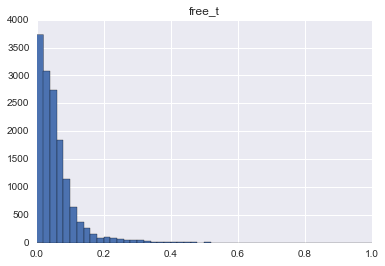

In [27]:
df[['block_id', 'free_t']].groupby('block_id').mean().hist(bins=50)

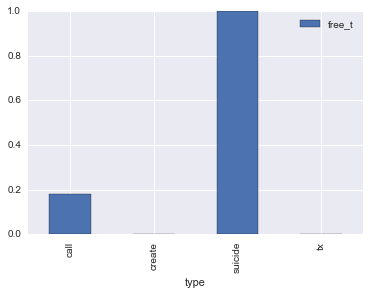

In [28]:
df[['type', 'free_t']].groupby('type').mean().plot(kind='bar')

Suicide it seems is always free. Create and tx always have a cost. About 20% of call events are free but non of the create events are. more details below.

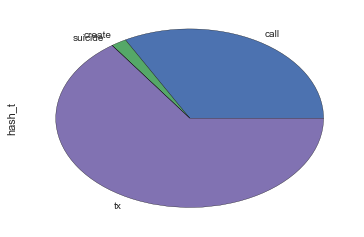

In [77]:
#shares by type of events
df[['hash_t', 'type']].groupby('type').count().hash_t.plot(kind='pie')

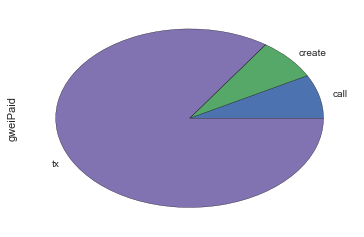

In [78]:
#fees paid by type
df[['hash_t', 'type','gweiPaid']].groupby('type').sum().gweiPaid.plot(kind='pie')

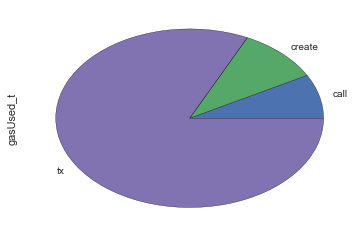

In [79]:
#gas used by type
df[['hash_t', 'type','gasUsed_t']].groupby('type').sum().gasUsed_t.plot(kind='pie')

In [93]:
#quick look at transactions
txdf = df[(df['type']=='tx')&(df.amount_gwei>0)].copy()
txdf['logGweiAmount'] = txdf.amount_gwei.apply(np.log10)
txdf['logGweiPrice'] = txdf.price_gwei.apply(np.log10)
txdf['logGasUsed'] = txdf.gasUsed_t.apply(np.log10)

In [94]:
txdf[['amount_gwei','price_gwei','gasUsed_t']].describe()

,amount_gwei,price_gwei,gasUsed_t
count,5.355870e+05,5.355870e+05,5.355870e+05
mean,1.014558e+09,2.830393e+01,2.945847e+04
std,1.769756e+09,9.185157e+01,8.174162e+04
min,1.000000e-09,1.000000e-09,2.100000e+04
25%,7.550040e+07,2.100000e+01,2.100000e+04
50%,2.009860e+08,2.100000e+01,2.100000e+04
75%,1.000026e+09,3.000000e+01,2.100000e+04
max,9.223372e+09,2.100000e+04,6.717000e+06


In [97]:
txdf[['logGweiAmount','logGweiPrice','logGasUsed']].describe()

,logGweiAmount,logGweiPrice,logGasUsed
count,535587.000000,535587.000000,535587.000000
mean,8.304347,1.331857,4.375389
std,1.058266,0.341281,0.184848
min,-9.000000,-9.000000,4.322219
25%,7.877949,1.322219,4.322219
50%,8.303166,1.322219,4.322219
75%,9.000011,1.477121,4.322219
max,9.964890,4.322219,6.827175


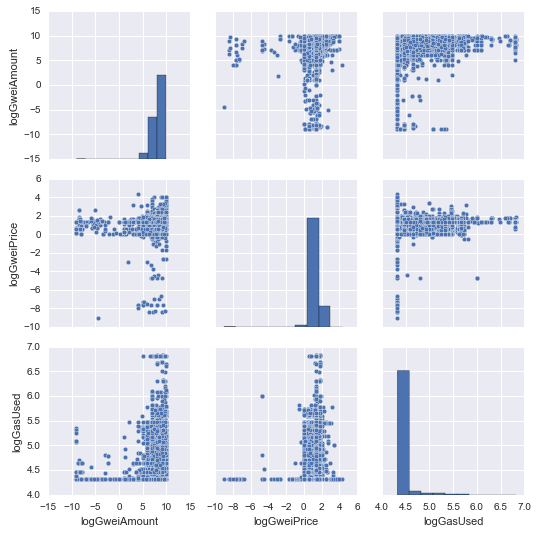

In [101]:
sns.pairplot(txdf[['logGweiAmount','logGweiPrice','logGasUsed']])

tx type is the only ones for which amount is non-zero. Moving forward we aren't looking at the ammount focusing on the gas amount used and the price paid for that gas.

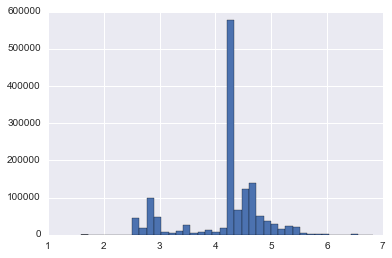

In [29]:
df[df.gasUsed_t>0].gasUsed_t.apply(np.log10).hist(bins=40)

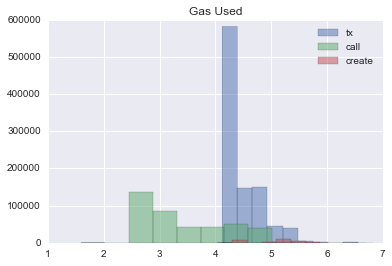

In [30]:
df[(df.gasUsed_t>0)&(df['type']=='tx')].gasUsed_t.apply(np.log10).hist(bins=10,alpha=.5)
df[(df.gasUsed_t>0)&(df['type']=='call')].gasUsed_t.apply(np.log10).hist(bins=10,alpha=.5)
df[(df.gasUsed_t>0)&(df['type']=='create')].gasUsed_t.apply(np.log10).hist(bins=10,alpha=.5)

plt.title('Gas Used')
plt.legend(['tx','call','create'])

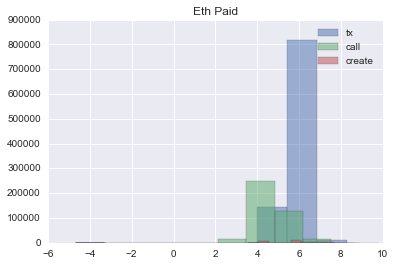

In [31]:
df[(df.gasUsed_t>0)&(df['type']=='tx')].gweiPaid.apply(np.log10).hist(bins=10,alpha=.5)
df[(df.gasUsed_t>0)&(df['type']=='call')].gweiPaid.apply(np.log10).hist(bins=10,alpha=.5)
df[(df.gasUsed_t>0)&(df['type']=='create')].gweiPaid.apply(np.log10).hist(bins=10,alpha=.5)

plt.title('Gwei Paid')
plt.legend(['tx','call','create'])

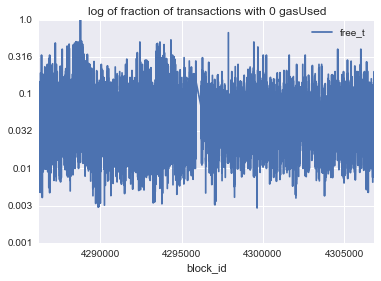

In [32]:
#compute the fraction of transactions with zero gasUsed by block
df[['block_id', 'free_t']].groupby('block_id').mean().apply(np.log10).plot()
plt.title('log of fraction of transactions with 0 gasUsed')
ax = plt.gca()
ax.set_yticklabels([round(10**y,3) for y in ax.get_yticks()])

In [33]:
signals = df[['block_id', 'free_t','type']].groupby(['type','block_id']).mean().reset_index()
signals.head()

,type,block_id,free_t
0,call,4286251,0.076923
1,call,4286252,0.162162
2,call,4286253,1.000000
3,call,4286254,0.200000
4,call,4286255,0.161765


In [34]:
signals.groupby('type').describe()

block_id        free_t
type                                     
call    count  1.372100e+04  13721.000000
        mean   4.294948e+06      0.214579
        std    5.898612e+03      0.201976
        min    4.286251e+06      0.000000
        25%    4.290063e+06      0.083333
        50%    4.293795e+06      0.160000
        75%    4.299650e+06      0.282609
        max    4.306841e+06      1.000000
create  count  7.499000e+03   7499.000000
        mean   4.294838e+06      0.000741
        std    5.935216e+03      0.021762
        min    4.286252e+06      0.000000
        25%    4.289918e+06      0.000000
        50%    4.293298e+06      0.000000
        75%    4.299634e+06      0.000000
        max    4.306839e+06      1.000000
suicide count  9.800000e+01     98.000000
        mean   4.294475e+06      1.000000
        std    5.057342e+03      0.000000
        min    4.286963e+06      1.000000
        25%    4.290188e+06      1.000000
        50%    4.293205e+06      1.000000
        75%    4.296963e+06      1.000000
        max    4.306466e+06      1.000000
tx      count  1.457000e+04  14570.000000
        mean   4.294948e+06      0.000000
        std    5.912447e+03      0.000000
        min    4.286251e+06      0.000000
        25%    4.290053e+06      0.000000
        50%    4.293774e+06      0.000000
        75%    4.299659e+06      0.000000
        max    4.306841e+06      0.000000

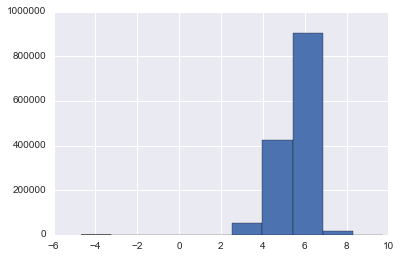

In [35]:
df[df.gweiPaid>0].gweiPaid.apply(np.log10).hist()

In [36]:
df.gasShare.describe()

count    1.494279e+06
mean     8.004330e-03
std      2.609830e-02
min      0.000000e+00
25%      1.452795e-03
50%      3.167304e-03
75%      7.455767e-03
max      1.000000e+00
Name: gasShare, dtype: float64

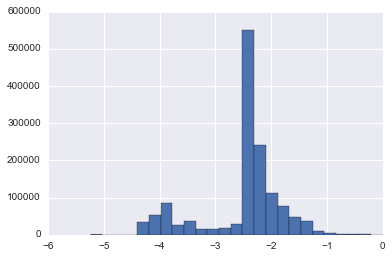

In [37]:
df[df.gasShare>0].gasShare.apply(np.log10).hist(bins=25)

In [55]:
#reduced dataframe
rdf = df[['gasUsed_t','gasShare','gweiPaid','gweiShare', 'price_gwei', 'type']].copy()

In [56]:
rdf.head()

,gasUsed_t,gasShare,gweiPaid,gweiShare,price_gwei,type
0,21000,0.054830,441000.0,0.051115,21.0,tx
1,9416,0.024585,197736.0,0.022919,21.0,call
2,21000,0.054830,441000.0,0.051115,21.0,tx
3,21000,0.054830,441000.0,0.051115,21.0,tx
4,21000,0.054830,441000.0,0.051115,21.0,tx


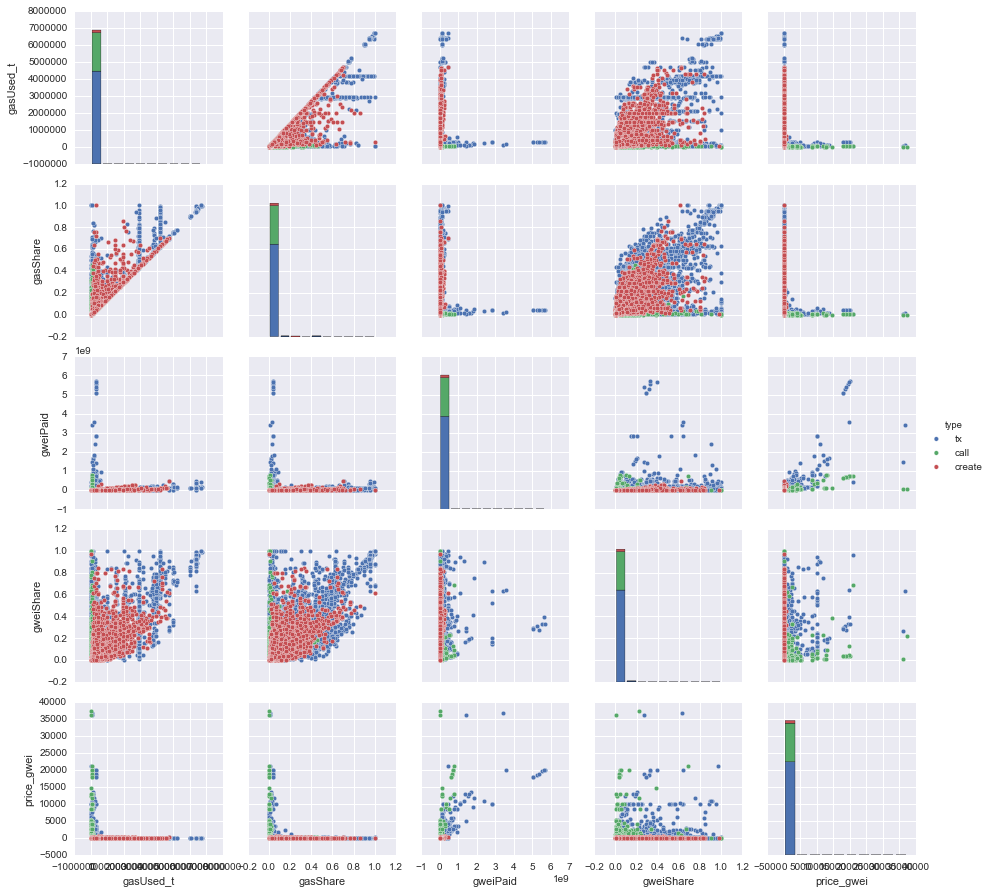

In [57]:
sns.pairplot(rdf[df.gweiPaid>0], hue="type")

In [62]:
#log10 values of reduced dataframe
ldf = rdf[df.gweiPaid>0].copy()
for c in ['gasUsed_t','gasShare','gweiPaid','gweiShare', 'price_gwei']:
    ldf[c] = ldf[c].apply(np.log10)

In [63]:
ldf.describe()

,gasUsed_t,gasShare,gweiPaid,gweiShare,price_gwei
count,1.404478e+06,1.404478e+06,1.404478e+06,1.404478e+06,1.404478e+06
mean,4.210493e+00,-2.528868e+00,5.482841e+00,-2.481160e+00,1.272349e+00
std,6.983038e-01,7.148782e-01,7.297942e-01,7.447058e-01,4.454878e-01
min,1.591065e+00,-5.238463e+00,-4.686998e+00,-1.270125e+01,-9.000000e+00
25%,4.322219e+00,-2.505209e+00,5.054445e+00,-2.813734e+00,1.301030e+00
50%,4.322219e+00,-2.491321e+00,5.644439e+00,-2.356061e+00,1.322219e+00
75%,4.572128e+00,-2.112984e+00,5.960484e+00,-2.012265e+00,1.602060e+00
max,6.827175e+00,0.000000e+00,9.755624e+00,0.000000e+00,4.571762e+00


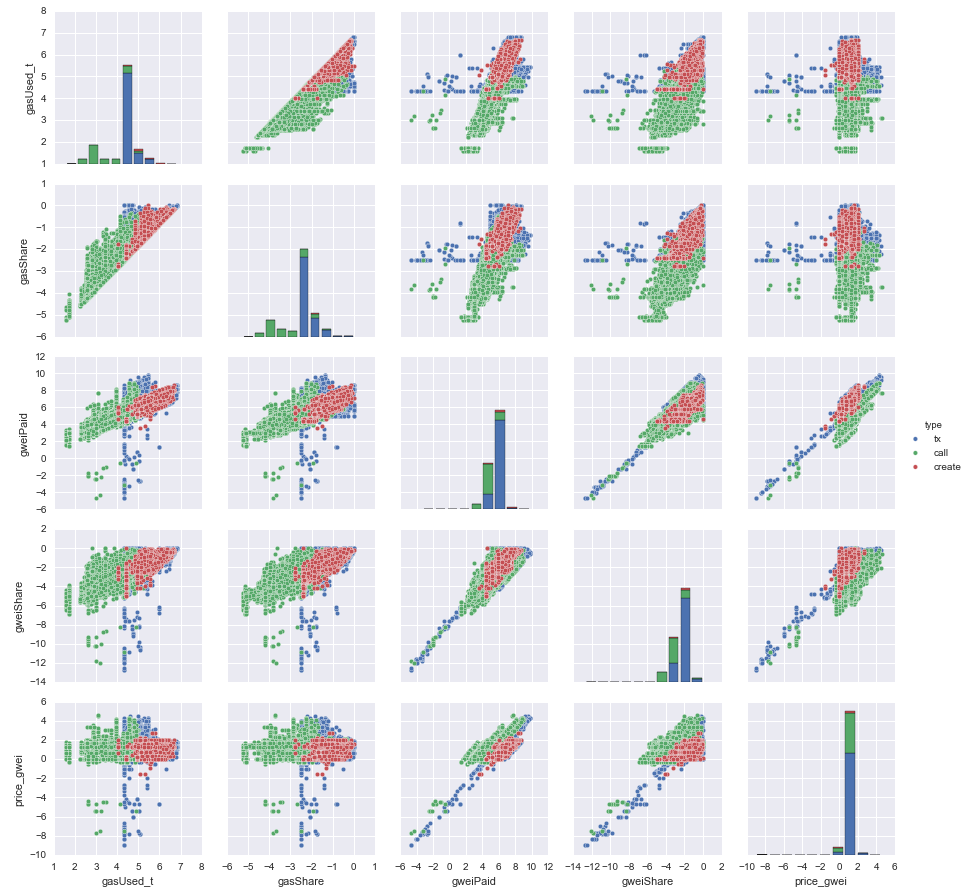

In [64]:
sns.pairplot(ldf, hue="type")

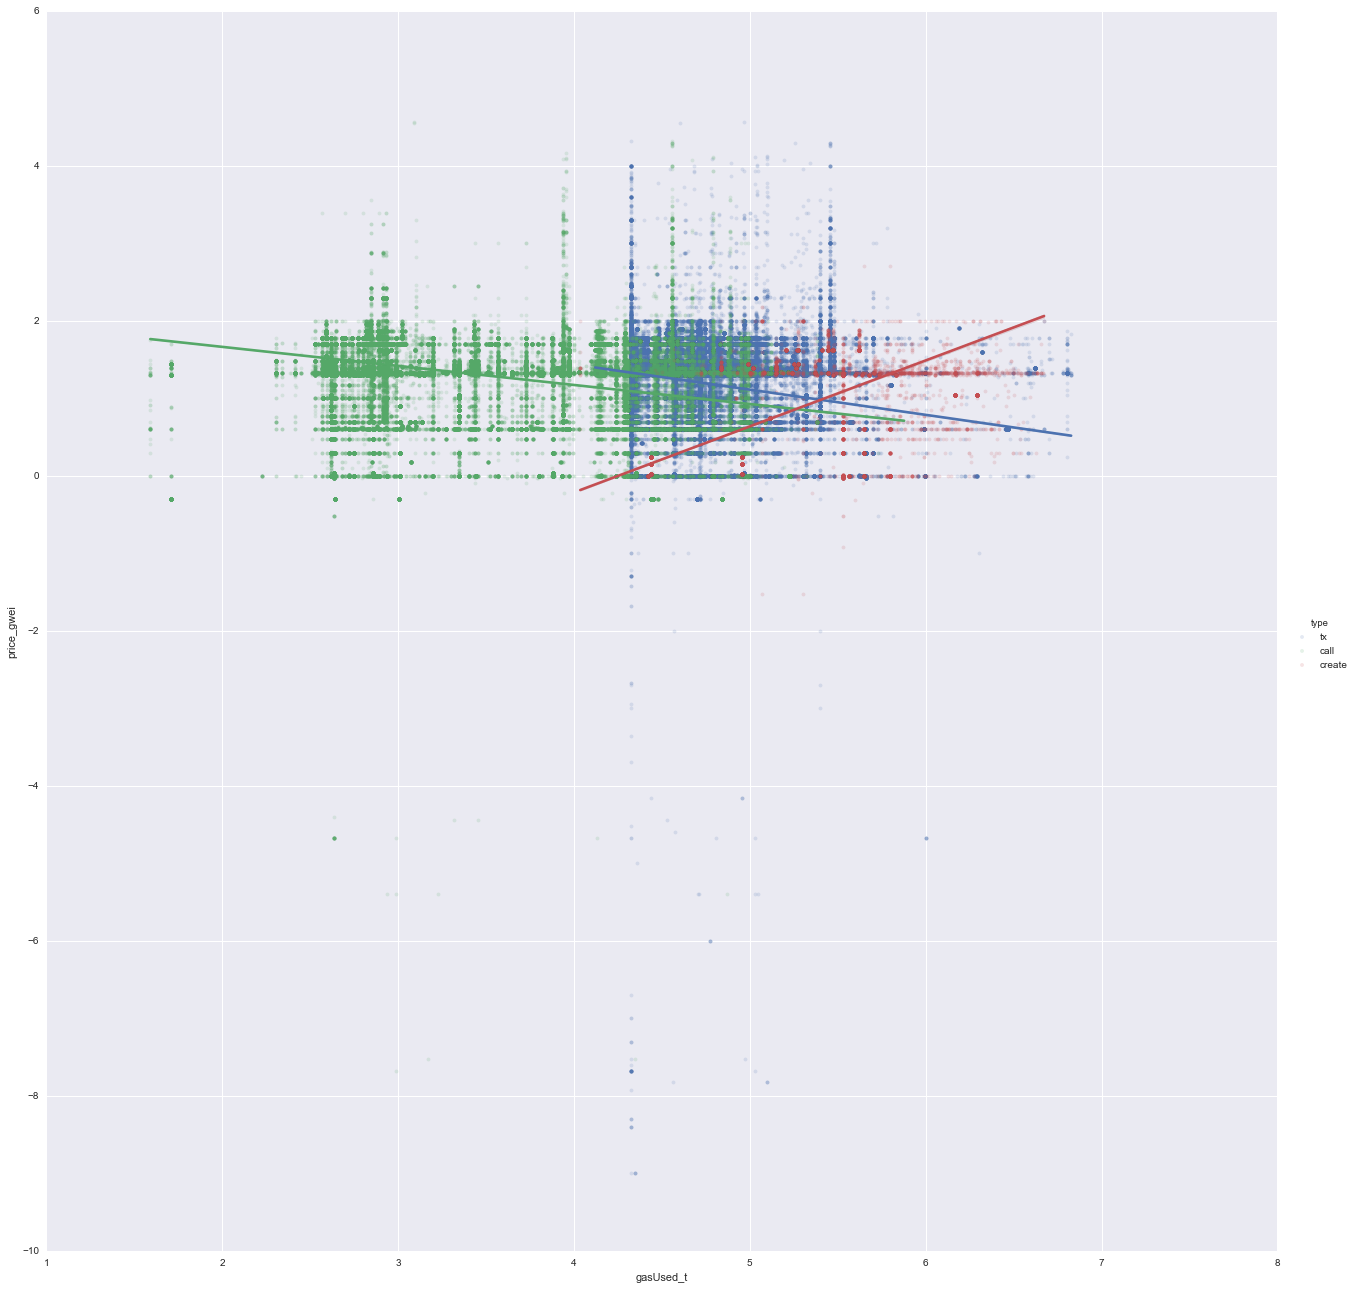

In [68]:
sns.lmplot(x="gasUsed_t", y="price_gwei", hue="type",truncate=True, size=18, data=ldf, scatter_kws={"s": 15,"alpha": .15})

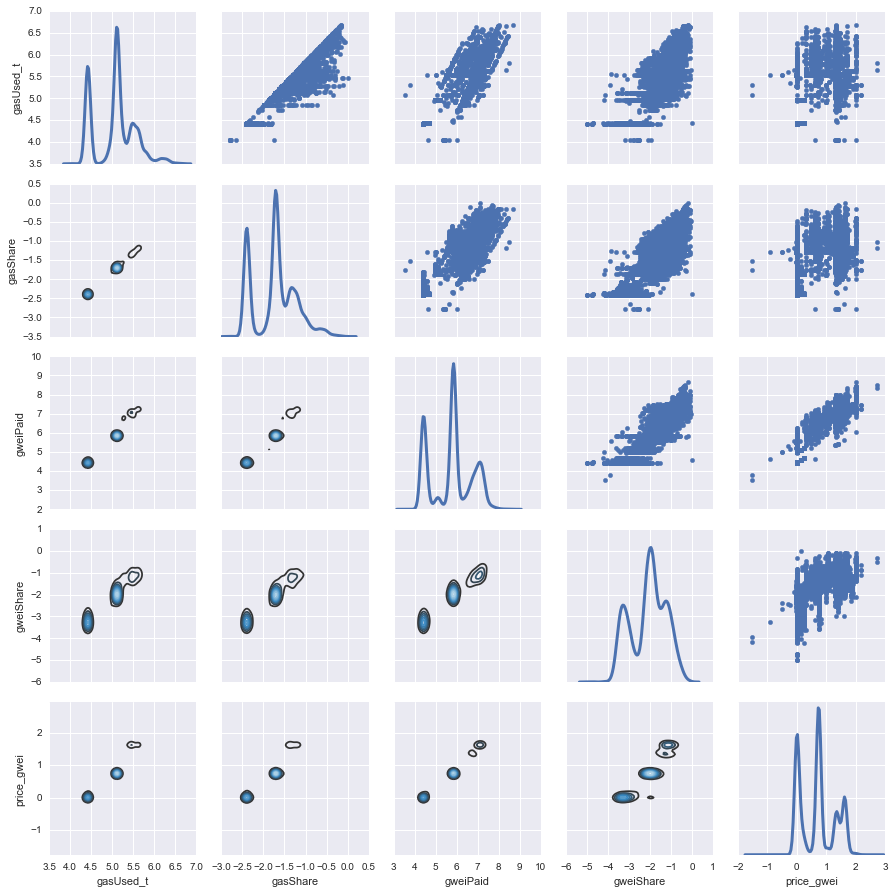

In [75]:
g = sns.PairGrid(ldf[ldf['type']=='create'], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)